Assignment 2

Question 1

Imports

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy . optimize import minimize
from scipy import linalg
import math
from copy import copy
import warnings
warnings.filterwarnings("ignore")


In [2]:
np.random.seed(0)
N = 100
half_n = N//2
r = 10
s1 = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s1*np.random.randn(half_n)
x1, y1 = (r+n)*np.cos(t), (r+n)*np.sin(t)

x_cir_cor, y_cir_cor = r*np.cos(t), r*np.sin(t)

X_circ = np.hstack((x1.reshape(half_n, 1), y1.reshape(half_n, 1 )))

m, b = -1, 2
x2 = np.linspace(-12, 12, half_n)
y2 = m*x2 + b + s1*np.random.randn(half_n)
X_line = np.hstack((x2.reshape(half_n, 1), y2.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))

x_con = np.concatenate([x1,x2])
y_con = np.concatenate([y1,y2])


In [6]:
e = 0.4
sam = 3
d = 50
p=0.99
num_s = np.log(1-p)/np.log(1-(1-e)**sam)

Estimation Manually

In [7]:
in_count = 0

while in_count<55:
    a1 = np.random.randint(0,100)
    a2 = np.random.randint(0,100)
    a3 = np.random.randint(0,100)

    x_cor1, y_cor1 = x_con[a1],y_con[a1]
    x_cor2, y_cor2 = x_con[a2],y_con[a2]
    x_cor3, y_cor3 = x_con[a3],y_con[a3]

    x_points = (x_cor1, x_cor2, x_cor3)
    y_points = (y_cor1, y_cor2, y_cor3)

    c = (x_cor1-x_cor2)**2 + (y_cor1-y_cor2)**2
    a = (x_cor2-x_cor3)**2 + (y_cor2-y_cor3)**2
    b = (x_cor3-x_cor1)**2 + (y_cor3-y_cor1)**2

    s = 2*(a*b + b*c + c*a) - (a*a + b*b + c*c)

    cen_x = (a*(b+c-a)*x_cor1 + b*(c+a-b)*x_cor2 + c*(a+b-c)*x_cor3) / s
    cen_y = (a*(b+c-a)*y_cor1 + b*(c+a-b)*y_cor2 + c*(a+b-c)*y_cor3) / s 

    ar = a**0.5
    br = b**0.5
    cr = c**0.5 

    r = ar*br*cr / ((ar+br+cr)*(-ar+br+cr)*(ar-br+cr)*(ar+br-cr))**0.5

    center = (cen_x, cen_y)

    up_t = r+s1*1.65
    low_t = r-s1*1.65
    
    in_count = 0
    in_list_x = []
    in_list_y = []
    for i in range(len(x_con)):
        if math.dist((x_con[i],y_con[i]),(cen_x,cen_y))>=low_t and math.dist((x_con[i],y_con[i]),(cen_x,cen_y))<=up_t:
            in_count+=1
            in_list_x.append(x_con[i])
            in_list_y.append(y_con[i])
            
    if in_count >=53 and r<20:
        print(in_count)
        break

53


In [8]:
# Coordinates of the 2D points
x = in_list_x
y = in_list_y

# coordinates of the barycenter
x_m = np.mean(x)
y_m = np.mean(y)

# calculation of the reduced coordinates
u = x - x_m
v = y - y_m

# linear system defining the center in reduced coordinates (uc, vc):
#    Suu * uc +  Suv * vc = (Suuu + Suvv)/2
#    Suv * uc +  Svv * vc = (Suuv + Svvv)/2
Suv  = sum(u*v)
Suu  = sum(u**2)
Svv  = sum(v**2)
Suuv = sum(u**2 * v)
Suvv = sum(u*v**2)
Suuu = sum(u**3)
Svvv = sum(v**3)

# Solving the linear system
A = np.array([[Suu, Suv], [Suv, Svv]])
B = np.array([ Suuu + Suvv, Svvv + Suuv ])/2.0
uc, vc = linalg.solve(A, B)

xc_1 = x_m + uc
yc_1 = y_m + vc

# Calculation of all distances from the center (xc_1, yc_1)
Ri_1      = np.sqrt((x-xc_1)**2 + (y-yc_1)**2)
R_1       = np.mean(Ri_1)
residu_1  = sum((Ri_1-R_1)**2)
residu2_1 = sum((Ri_1**2-R_1**2)**2)

cen = (xc_1,yc_1)

Plotting the Final Output

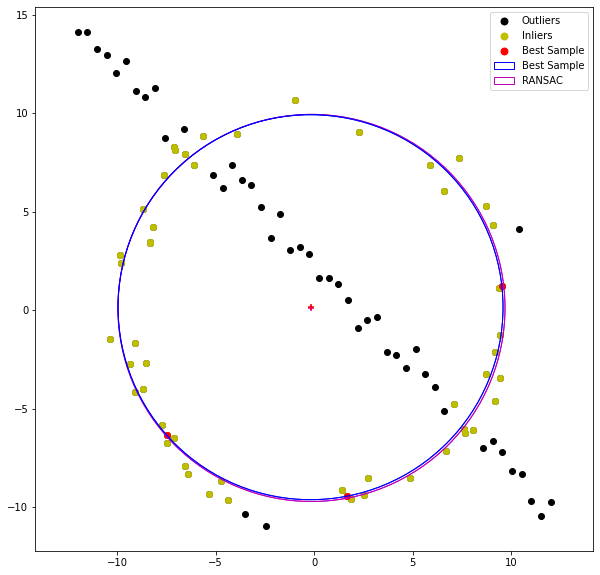

In [9]:
fig, ax2 = plt.subplots(1,1,figsize=(10,10))
ax2.axis('equal')

ax2.scatter(xc_1,yc_1,color='m',marker='+')
ax2.scatter(cen_x,cen_y,color='r',marker='+')
ax2.scatter(x1, y1, color='k')
ax2.scatter(x2, y2, color='k')
ax2.scatter(x, y,color='y')
ax2.scatter(x_points, y_points, color='r')

circle = plt.Circle((xc_1, yc_1), R_1, color='m',fill=False)
ax2.add_artist(circle)
ax2.add_patch(circle)

circle2 = plt.Circle((cen_x, cen_y), r, color='b',fill=False)
ax2.add_artist(circle2)
ax2.add_patch(circle2)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Outliers',markerfacecolor='k', markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='Inliers',markerfacecolor='y', markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='Best Sample',markerfacecolor='r', markersize=9),
                   Patch(facecolor='w', edgecolor='b',label='Best Sample'),
                   Patch(facecolor='w', edgecolor='m',label='RANSAC')]

ax2.legend(handles=legend_elements)
plt.show()

Question 2

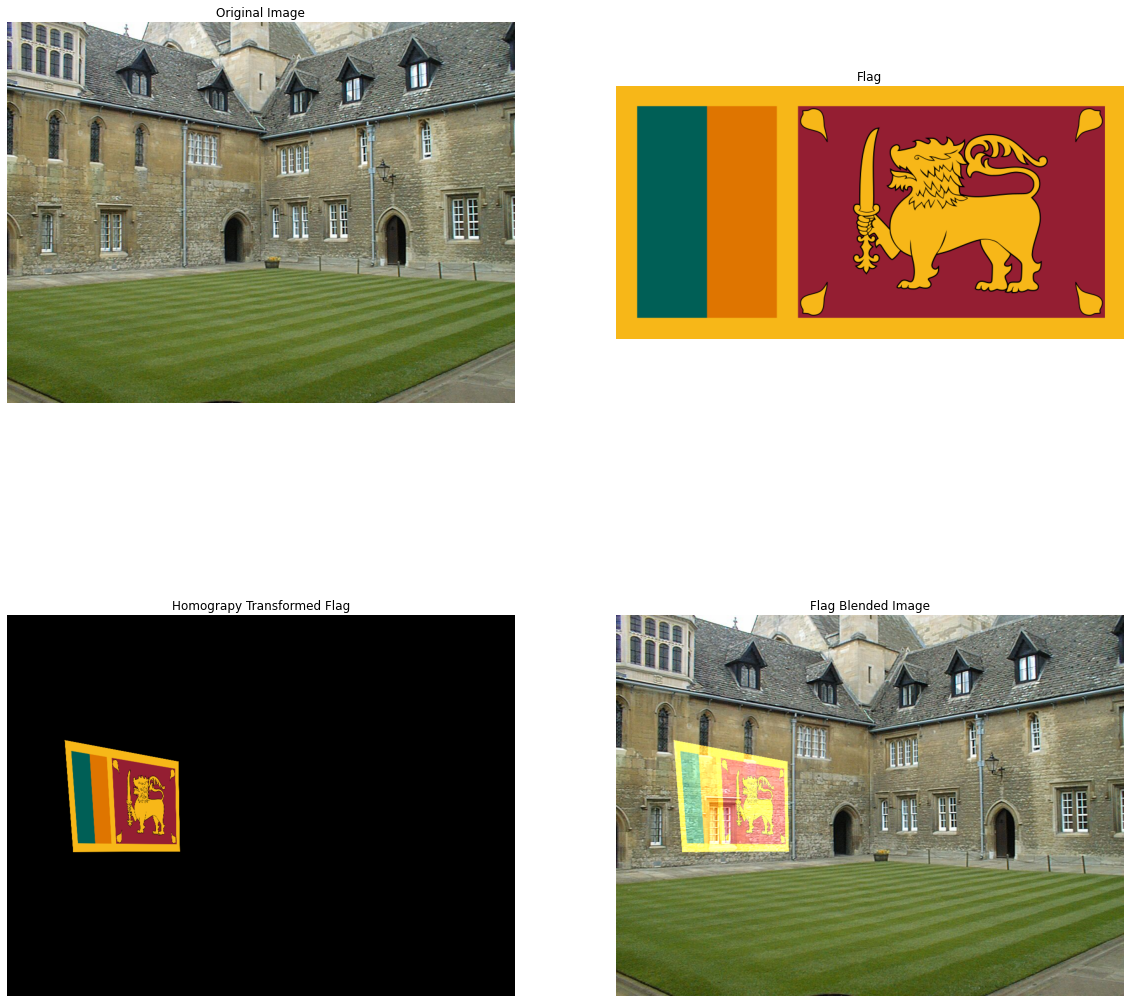

In [28]:
def MouseHandling(event,x,y,f,pram):
    global temp2,click_points
    if event == cv.EVENT_LBUTTONDOWN:
        cv.circle(temp2 ,(x,y), 2, (255,255,0), 5, cv.LINE_AA)
        cv.imshow("Image",temp2)
        if len(click_points)<4:
            click_points = np.append(click_points,[(x,y)],axis=0)
    return

hall = cv.imread("hall.jpg")
flag = cv.imread("sri lankan flag.png")

h_w, h_h = hall.shape[1], hall.shape[0]
f_w, f_h = flag.shape[1], flag.shape[0]

point_coord = np.array([[0,0], [0,f_h-1], [f_w-1,f_h-1], [f_w-1,0]])

cv.namedWindow("Image")

temp1 = cv.cvtColor(hall, cv.COLOR_BGR2RGB)
temp2 = cv.cvtColor(temp1, cv.COLOR_RGB2BGR)
click_points = np.empty((0,2))

cv.setMouseCallback("Image", MouseHandling)

cv.imshow("Image",temp2)
cv.waitKey(0)

Homograpy_Matrix, status = cv.findHomography(click_points, point_coord)

trans_flag = cv.warpPerspective(flag, np.linalg.inv(Homograpy_Matrix), (h_w, h_h))

blend_image = cv.addWeighted(hall, 1, trans_flag, 0.8, 0)

cv.imshow("Image",blend_image)
cv.waitKey(0)
cv.destroyAllWindows()

fig, ax = plt.subplots(2,2, figsize=(20,20))

ax[0,0].imshow(cv.cvtColor(hall,cv.COLOR_BGR2RGB))
ax[0,0].set_title("Original Image")

ax[0,1].imshow(cv.cvtColor(flag,cv.COLOR_BGR2RGB))
ax[0,1].set_title("Flag")

ax[1,0].imshow(cv.cvtColor(trans_flag,cv.COLOR_BGR2RGB))
ax[1,0].set_title("Homograpy Transformed Flag")

ax[1,1].imshow(cv.cvtColor(blend_image,cv.COLOR_BGR2RGB))
ax[1,1].set_title("Flag Blended Image")

for i in range (2):
    for j in range(2):
        ax[i,j].axis("off")



Question 3
Part 1

In [86]:
img0 = cv.imread(r'D:\Sem 4 ACA\Machine Vision\Assignment_2\EN2550-Assignment-2\img1.ppm',cv.IMREAD_COLOR)
img5 = cv.imread(r'D:\Sem 4 ACA\Machine Vision\Assignment_2\EN2550-Assignment-2\img4.ppm',cv.IMREAD_COLOR)

def kp_des(img1,img2):
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=100000)
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    pts1 = []
    pts2 = []
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
            good.append([m])
    return pts1,pts2,good,kp1,kp2

pts1,pts2,good,kp1,kp2=kp_des(img0,img5)
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
good=np.array(good)
img3 = cv.drawMatchesKnn(img0,kp1,img5,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

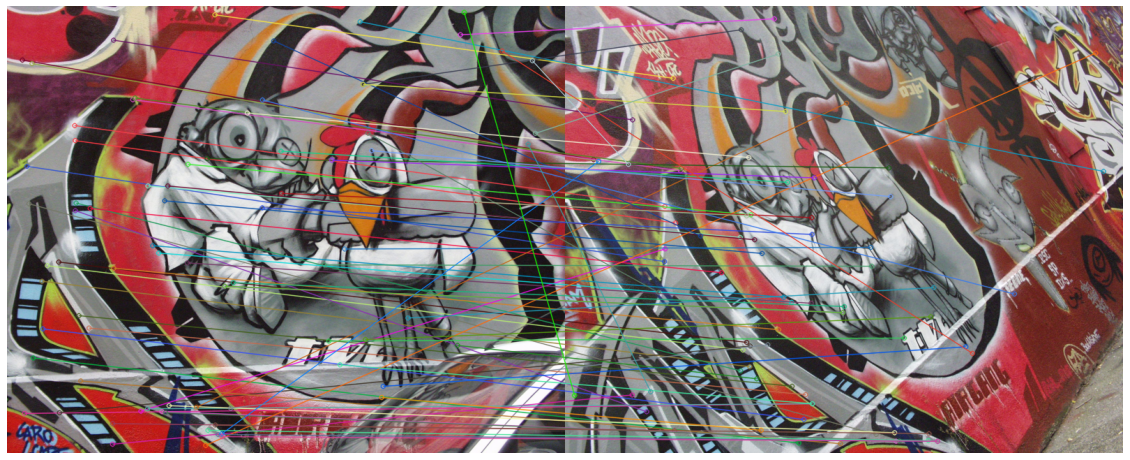

In [87]:
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img3)
plt.axis('off')
plt.show()